## STAN47 Lab 5 Recurrent Neural Networks (RNN)
* Instructors: [Małgorzata Bogdan](https://portal.research.lu.se/sv/persons/malgorzata-bogdan), [Hanqing Wu](https://portal.research.lu.se/en/persons/hanqing-wu)

Recurrent Neural Networks (RNNs) are a powerful type of artificial neural network. They are designed to recognize patterns in sequences of data like text, genomes, handwriting, or audios. Unlike feedforward neural networks, which process inputs independently, RNNs have internal states (memory) that allow them to process sequences of inputs. This means they can remember information from each step in the sequence and use it in the next step, making them particularly effective for tasks where the order of inputs matters. For more detailed information, please refer to [Chapter 10 of our textbook](https://www.deeplearningbook.org/contents/rnn.html).

## RNN for Audio Recognition

In this section, we are going to preprocess audio files in the WAV format and build and train a basic automatic speech recognition (ASR) model for recognizing eight different words. You will use a portion of the Speech Commands dataset (Warden, 2018), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition systems are complex. But, like image classification with the Fashion-MNIST dataset, this simple example will provide you with an idea about the application of RNN models.

In [5]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 2777
tf.random.set_seed(seed)
np.random.seed(seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.autograph.set_verbosity(0) 

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


We download the dataset.

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 16s 0us/step


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


Here we perform a train-test split.

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
# We further split the validation set into the validation set and the test set
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


An audio file can be conceptualized as a sequence of oscillations. The following visualization allows us to better understand the intricate patterns and structures within the audio data.

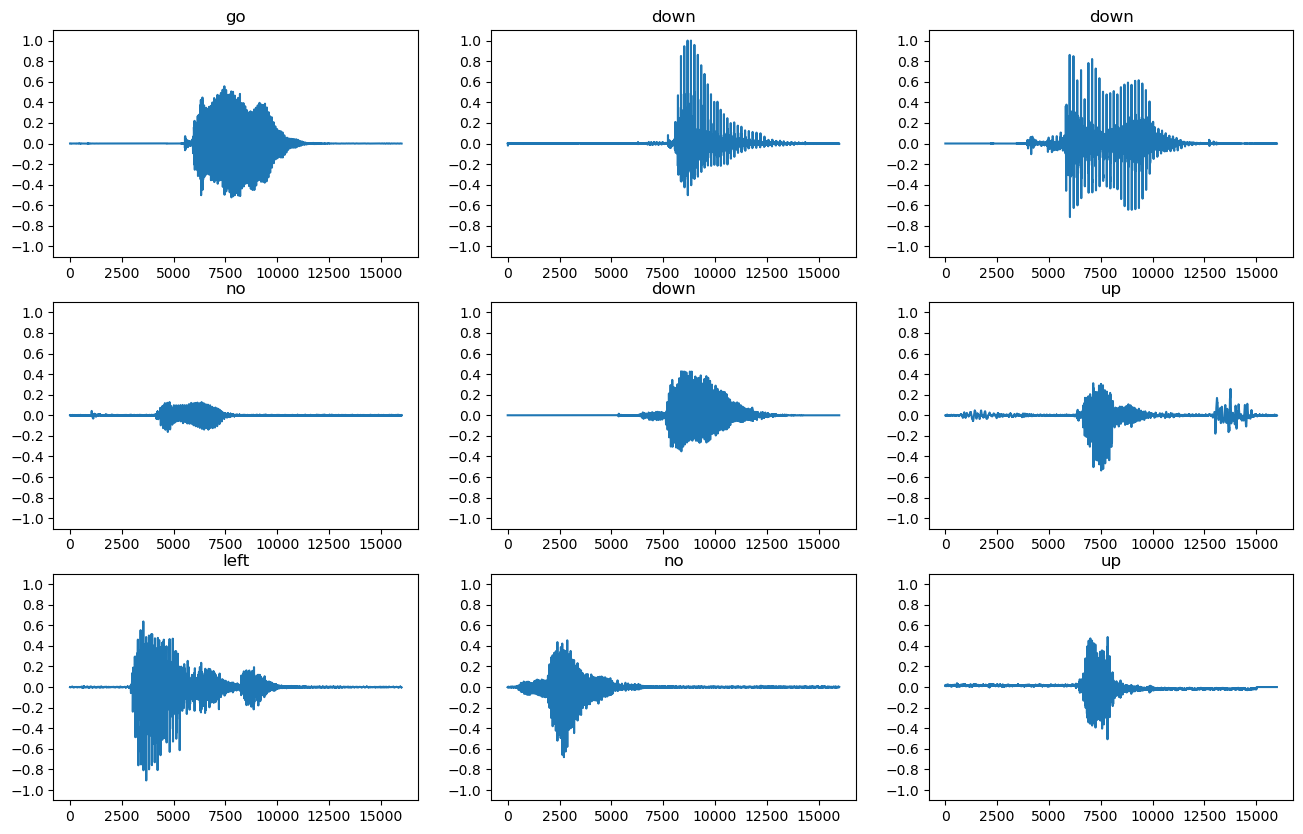

In [8]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

The function `get_spectrogram` performs the [Short-Time Fourier Transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform), a critical technique in audio signal processing. The STFT converts wave-form data into a spectrogram and provides a time-frequency representation, enabling us to analyze the frequency content of the audio signal over time.

This is particularly valuable for audio recognition tasks. The STFT allows us to extract meaningful features from the audio signal. By transforming the audio signal from the time domain to the time-frequency domain, we gain a more detailed understanding of the signal’s characteristics.

In [9]:
def get_spectrogram(waveform):
    # Convert the wave-form to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    return spectrogram

Here are three simple examples.

In [10]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


In [11]:
# A function that helps to convert the entire dataset
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [27]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

In [28]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129)


The normalization layer is utilized to standardize the input data. By invoking the adapt method on the training data prior to the model compilation, the layer is calibrated to normalize future inputs based on the statistical distribution of the training data.

In [15]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda x, label: x))

The model presented below is a simple Recurrent Neural Network (RNN) that incorporates fully-connected RNN layers. For such layers, the output from each step is looped back as the input for the next step, creating a ‘recurrent’ structure. A key parameter in this setup is `return_sequences`. When `return_sequences` is set to `True`, it indicates that the layer will output the full sequence of outputs across time, rather than just the output of the last timestep. And under this circumstance, we could stack another RNN layer on top of the current one, which can potentially enhance the model’s predictive power by allowing it to learn more complex patterns within the data. For more information regarding `layers.SimpleRNN`, please refer to [the corresponding Keras webpage](https://keras.io/api/layers/recurrent_layers/simple_rnn/).

In [32]:
model_rnn = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(16, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_labels, activation="softmax"),
])

In [33]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 124, 129)          259       
 on)                                                             
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 124, 64)           12416     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                1296      
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 15579 (60.86 KB)
Trainable params: 15320 (59.84 KB)
Non-trainable params: 259 (1.02 KB)
__________________

### Task 1

Using the following configuration of hyperparameters, train `model_rnn` on the training set. Report the training and validation accuracy, does this model perform well in classifying audios from different categories?

In [34]:
OPTIMIZER = tf.keras.optimizers.legacy.Adam(learning_rate = 5e-4, decay=1e-4, clipvalue=1)
LOSS = "sparse_categorical_crossentropy"
METRICS = ["accuracy"]

EPOCHS = 20
VERBOSE = 1

model_rnn.compile(OPTIMIZER,
                 LOSS,
                 METRICS)

---

In [36]:
history = model_rnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    verbose=VERBOSE
)


Epoch 1/20
100/100 [==============================] - 3s 25ms/step - loss: 2.0888 - accuracy: 0.1312 - val_loss: 2.0795 - val_accuracy: 0.1367
Epoch 2/20
100/100 [==============================] - 3s 26ms/step - loss: 2.0771 - accuracy: 0.1383 - val_loss: 2.0752 - val_accuracy: 0.1393
Epoch 3/20
100/100 [==============================] - 3s 26ms/step - loss: 2.0127 - accuracy: 0.1741 - val_loss: 1.9553 - val_accuracy: 0.1862
Epoch 4/20
100/100 [==============================] - 3s 26ms/step - loss: 1.9099 - accuracy: 0.2081 - val_loss: 1.9070 - val_accuracy: 0.2096
Epoch 5/20
100/100 [==============================] - 3s 26ms/step - loss: 1.8863 - accuracy: 0.2164 - val_loss: 1.8895 - val_accuracy: 0.2057
Epoch 6/20
100/100 [==============================] - 3s 26ms/step - loss: 1.8574 - accuracy: 0.2258 - val_loss: 1.8938 - val_accuracy: 0.1953
Epoch 7/20
100/100 [==============================] - 3s 26ms/step - loss: 1.8542 - accuracy: 0.2255 - val_loss: 1.8976 - val_accuracy: 0.2005

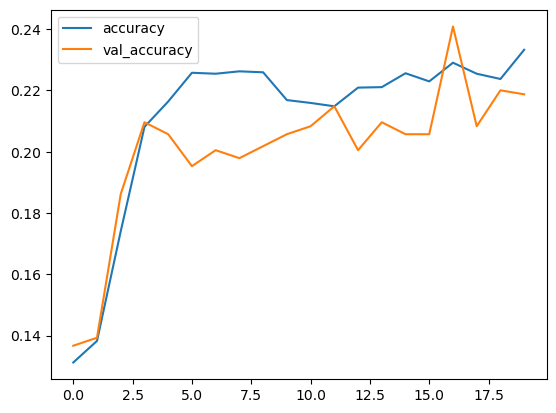

In [38]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

The model does not preforme well, it has a validation accuracy just over 20%. The model preformce just a little bit better then plain guessing.

Standard RNNs sometimes can struggle to carry information through many time steps, making it difficult for them to learn from early inputs in a long sequence. This is known as the vanishing gradient problem. Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture that is designed to remember long-term dependencies in sequence data. It uses special units in addition to the standard units, which helps it avoid the vanishing gradient problem. These special units include a memory cell and three gates: an input gate, a forget gate, and an output gate. The gates control the flow of information into, out of, and within the memory cell. This structure allows LSTMs to store and retrieve information over long periods of time, making them highly effective for tasks involving long sequences. Another variant of the RNN is the Gated Recurrent Unit (GRU). Similar to the LSTM, the GRU is designed to combat the vanishing gradient problem. It simplifies the LSTM architecture by combining the forget and input gates into a single ‘update gate.’ This makes GRUs computationally more efficient than LSTMs, while still retaining their ability to model long-term dependencies. 

You may establish models with LSTM or GRU layers with `keras.layers.LSTM` and `keras.layers.GRU` respectively.

### Task 2

Develop two additional models, `model_lstm` and `model_gru`, by substituting the simple RNN layers in `model_rnn` with LSTM and GRU layers, respectively. Train these models using the identical hyperparameters as `model_rnn`. Compare the training speed of these models with that of `model_rnn`. Evaluate the performance of `model_lstm` and `model_gru` in comparison to `model_rnn` in terms of accuracy. Specifically, plot the training and validation accuracy of all three models for a clear comparison. Among the three models, which one achieves the best validation accuracy? Evaluate this model on the test set. 

In [43]:
def one_hot_encode(feature, label):
    label = tf.one_hot(label, depth=num_labels) 
    return feature, label

train_spectrogram_ds = train_spectrogram_ds.map(one_hot_encode)
val_spectrogram_ds = val_spectrogram_ds.map(one_hot_encode)

In [44]:
# LSTM Model
model_lstm = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(16, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_labels, activation="softmax"),
])

# GRU Model
model_gru = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.GRU(64, return_sequences=True),
    layers.GRU(16, return_sequences=False),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_labels, activation="softmax"),
])

In [45]:
# Compile and train LSTM model
model_lstm.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

history_lstm = model_lstm.fit(train_spectrogram_ds, 
                              validation_data=val_spectrogram_ds, 
                              epochs=EPOCHS, 
                              verbose=VERBOSE)


Epoch 1/20
100/100 [==============================] - 8s 72ms/step - loss: 1.9668 - accuracy: 0.1956 - val_loss: 1.9084 - val_accuracy: 0.2174
Epoch 2/20
100/100 [==============================] - 7s 73ms/step - loss: 1.8743 - accuracy: 0.2211 - val_loss: 1.8732 - val_accuracy: 0.2461
Epoch 3/20
100/100 [==============================] - 7s 71ms/step - loss: 1.8476 - accuracy: 0.2308 - val_loss: 1.8049 - val_accuracy: 0.2435
Epoch 4/20
100/100 [==============================] - 7s 73ms/step - loss: 1.7619 - accuracy: 0.2803 - val_loss: 1.7641 - val_accuracy: 0.3398
Epoch 5/20
100/100 [==============================] - 7s 73ms/step - loss: 1.6955 - accuracy: 0.3323 - val_loss: 1.7210 - val_accuracy: 0.2865
Epoch 6/20
100/100 [==============================] - 8s 75ms/step - loss: 1.6791 - accuracy: 0.3119 - val_loss: 1.6162 - val_accuracy: 0.3333
Epoch 7/20
100/100 [==============================] - 7s 74ms/step - loss: 1.5471 - accuracy: 0.3528 - val_loss: 1.5858 - val_accuracy: 0.3307

In [46]:
# Compile and train GRU model
model_gru.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])


history_gru = model_gru.fit(train_spectrogram_ds,
                            validation_data=val_spectrogram_ds, 
                            epochs=EPOCHS, 
                            verbose=VERBOSE)



Epoch 1/20
100/100 [==============================] - 7s 65ms/step - loss: 2.0393 - accuracy: 0.1570 - val_loss: 1.9024 - val_accuracy: 0.2044
Epoch 2/20
100/100 [==============================] - 7s 64ms/step - loss: 1.7529 - accuracy: 0.2684 - val_loss: 1.6797 - val_accuracy: 0.3320
Epoch 3/20
100/100 [==============================] - 7s 65ms/step - loss: 1.4446 - accuracy: 0.4194 - val_loss: 1.3088 - val_accuracy: 0.4779
Epoch 4/20
100/100 [==============================] - 7s 64ms/step - loss: 1.1258 - accuracy: 0.5230 - val_loss: 1.1194 - val_accuracy: 0.5352
Epoch 5/20
100/100 [==============================] - 7s 64ms/step - loss: 0.9630 - accuracy: 0.5769 - val_loss: 1.0103 - val_accuracy: 0.5781
Epoch 6/20
100/100 [==============================] - 7s 65ms/step - loss: 0.8445 - accuracy: 0.6359 - val_loss: 0.9517 - val_accuracy: 0.6068
Epoch 7/20
100/100 [==============================] - 7s 64ms/step - loss: 0.7538 - accuracy: 0.6805 - val_loss: 0.8166 - val_accuracy: 0.6719

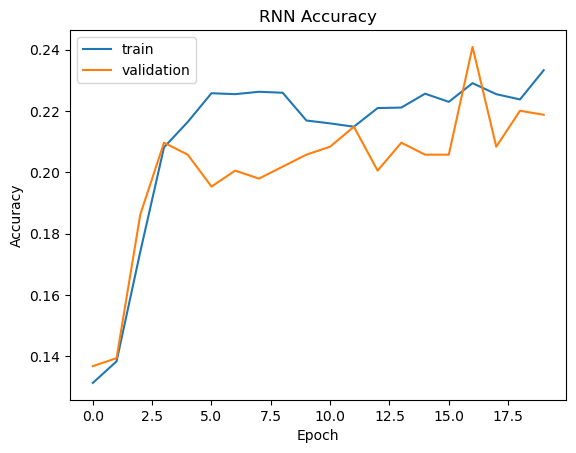

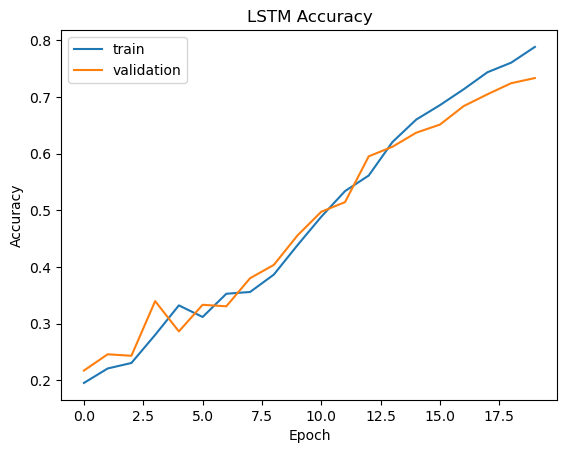

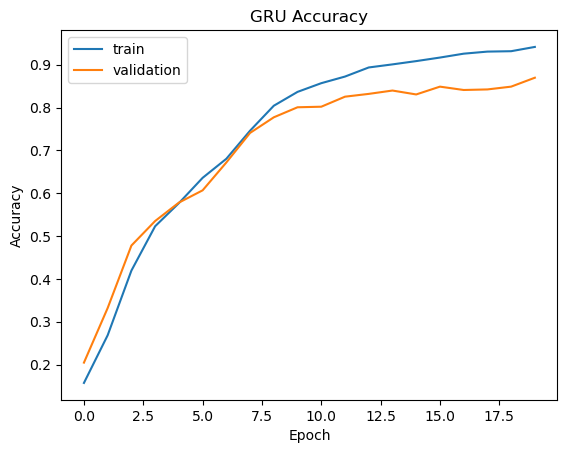

In [48]:
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Plot for each model
plot_accuracy(history, 'RNN Accuracy')
plot_accuracy(history_lstm, 'LSTM Accuracy')
plot_accuracy(history_gru, 'GRU Accuracy')

RNN Model: The first image shows a model with relatively low accuracy that does not improve significantly over epochs. The training and validation accuracy are close, suggesting that the model is not overfitting, but the overall performance is poor, indicating that the model might be underfitting the data.

LSTM Model: The second image depicts the LSTM model, which shows a significant improvement in performance compared to the RNN. The accuracy for both training and validation increases steadily over epochs. The LSTM seems to be learning effectively and generalizing well since the validation accuracy follows the training accuracy trend.

GRU Model: The third image shows the GRU model, which also displays a steady increase in accuracy over epochs and achieves the highest accuracy among the three models. The training and validation lines suggest that the model is learning effectively and is not overfitting, as the validation accuracy closely tracks the training accuracy.

---

All the recurrent networks we’ve considered so far have a ‘causal’, one-directional structure. However, many applications require predictions that depend on the entire input sequence. Take audio recognition, for instance. The end of a spoken word can provide context for the beginning of that word. A bidirectional layer addresses this by processing the audio input from both start to end and end to start, offering a richer representation of the audio data. This allows it to capture patterns that might be missed by a one-directional network. In Keras, achieving this is as simple as using `layers.Bidirectional` to wrap a recurrent layer, thereby creating its bidirectional counterpart.

### Task 3

Drawing on the knowledge we’ve acquired in this lab, your task is to design and train a recurrent neural network model using the hyperparameter configured above. Try to attain an accuracy of at least 0.88 on the test set.

In [50]:
# Create the Bidirectional RNN model
model_bidirectional = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Using dropout for regularization
    layers.Dense(num_labels, activation='softmax')
])

In [51]:
model_bidirectional.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [52]:
history_bidirectional = model_bidirectional.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    verbose=VERBOSE
)


Epoch 1/20
100/100 [==============================] - 13s 109ms/step - loss: 1.8911 - accuracy: 0.2527 - val_loss: 1.6967 - val_accuracy: 0.3125
Epoch 2/20
100/100 [==============================] - 11s 105ms/step - loss: 1.7065 - accuracy: 0.3114 - val_loss: 1.6139 - val_accuracy: 0.3815
Epoch 3/20
100/100 [==============================] - 11s 108ms/step - loss: 1.7078 - accuracy: 0.3128 - val_loss: 1.5207 - val_accuracy: 0.4232
Epoch 4/20
100/100 [==============================] - 11s 106ms/step - loss: 1.4780 - accuracy: 0.4394 - val_loss: 1.2931 - val_accuracy: 0.5456
Epoch 5/20
100/100 [==============================] - 11s 105ms/step - loss: 1.2722 - accuracy: 0.5323 - val_loss: 1.1326 - val_accuracy: 0.5872
Epoch 6/20
100/100 [==============================] - 11s 107ms/step - loss: 1.0680 - accuracy: 0.6108 - val_loss: 0.9902 - val_accuracy: 0.6562
Epoch 7/20
100/100 [==============================] - 11s 106ms/step - loss: 0.9433 - accuracy: 0.6736 - val_loss: 0.7866 - val_ac

In [63]:
test_loss, test_accuracy = model_bidirectional.evaluate(test_spectrogram_ds)
print(f"Test accuracy: {test_accuracy}")

13/13 [==============================] - 1s 36ms/step - loss: 0.4864 - accuracy: 0.8618
Test accuracy: 0.8617788553237915


The model gets a accuracy of 92%, a validation accraucy of 87% and a test accruacy of 86%. A way to make the model better is by implementing early stopping and increasse the number of epoachs. 

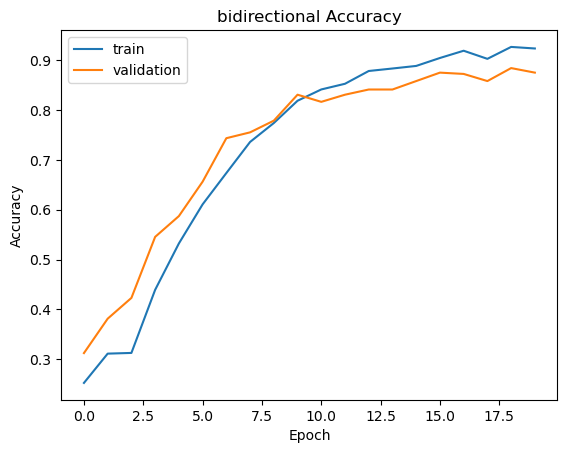

In [64]:
plot_accuracy(history_bidirectional, 'bidirectional Accuracy')


---

Now that we’ve developed an RNN model achieving a high accuracy, it’s beneficial to visually examine its classification performance on the test set.

### Task 4

Analyze the model you trained in Task 3 by classifying the audio samples in the test set. Construct a confusion matrix and visualize this matrix using a heatmap to gain detailed insights into the model’s performance. Identify the two words that your model finds most challenging to distinguish.

2/2 [==============================] - 0s 22ms/step


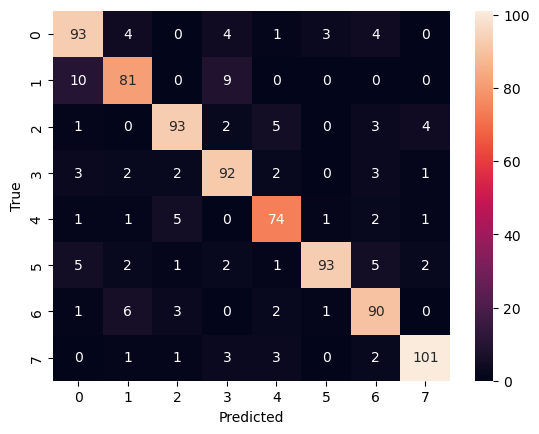

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
predicted_labels = []
for inputs, labels in test_spectrogram_ds:
    preds = model_bidirectional.predict(inputs)
    preds = np.argmax(preds, axis=1) # Convert predictions to label index
    true_labels.extend(labels.numpy()) # Collect the true labels
    predicted_labels.extend(preds) # Collect the predicted labels

# Now true_labels and predicted_labels should have the same length
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The model seams to have a problem with preticting the audio for class 1 and 0, most noticeable in the row ehre class 1 is true.  Futher more the models seasm to have a hard time with class 5.

---

## RNN for Traffic Forecasting

Apart from audio recognition, another task that RNN excels in is time series forecasting. This is because RNNs have the ability to process sequential data and capture temporal dependencies, which is crucial in time series forecasting. As an example, let us investigate the widely used PEMS-BAY dataset.

The PEMS-BAY dataset is a collection of traffic data used for traffic prediction. It contains 6 months of traffic readings (the average number of cars that passed by a sensor in a given interval) from January 1, 2017, to May 31, 2017, collected every 5 minutes by 325 traffic sensors in the San Francisco Bay Area. All missing values are filled with linear interpolation.

The aim for this investigation is to use the traffic readings from the previous 12 periods to predict the traffic readings for the next 12 periods. Note that if you have insufficient computer memory issues, you may decrease the size of the training, test, and validation dataset by the same ratio (e.g. by a factor of 5).

In [6]:
# Load the dataset
pb_train = np.load("train.npz")
pb_test = np.load("test.npz")
pb_val = np.load("val.npz")

In [7]:
pb_train_x = pb_train['x']
print(pb_train_x.shape)
pb_train_y = pb_train['y'][:,:,:,0]

(36465, 12, 325, 2)


In [8]:
# To avoid potential memory issue
del pb_train
import gc
gc.collect()

22

In [9]:
pb_test_x = pb_test['x']
pb_test_y = pb_test['y'][:,:,:,0]

del pb_test

In [10]:
pb_val_x = pb_val['x'][:,:,:,:]
pb_val_y = pb_val['y'][:,:,:,0]

del pb_val

In [11]:
train_tod = pb_train_x[:, 0, :, 1]
test_tod = pb_test_x[:, 0, :, 1]
val_tod = pb_val_x[:, 0, :, 1]

The original dataset is four-dimensional. However, the value in the second attribute of the fourth dimension simply represents a normalized value that indicates the time of day (1 out of 288) when the traffic reading was collected. To make the dataset more efficient, we can extract this information and reshape the dataset accordingly. The resulting input sequence will then have a length of 13, comprising the traffic readings from the previous 12 periods, plus the value indicating the time of day.

In [12]:
dim1, dim2 = train_tod.shape
train_tod = train_tod.reshape((dim1, 1, dim2))
dim1, dim2 = test_tod.shape
test_tod = test_tod.reshape((dim1, 1, dim2))
dim1, dim2 = val_tod.shape
val_tod = val_tod.reshape((dim1, 1, dim2))

In [13]:
pb_train_x_new = np.concatenate([train_tod, pb_train_x[:, :, :, 0]], axis=1)
pb_test_x_new = np.concatenate([test_tod, pb_test_x[:, :, :, 0]], axis=1)
pb_val_x_new = np.concatenate([val_tod, pb_val_x[:, :, :, 0]], axis=1)

In [14]:
norm_layer_x = layers.Normalization(axis=1)
norm_layer_x.adapt(pb_train_x_new)
norm_layer_y = layers.Normalization(axis=1)
norm_layer_y.adapt(pb_train_y)

In [15]:
pb_train_x_normed = norm_layer_x(pb_train_x_new)
pb_test_x_normed = norm_layer_x(pb_test_x_new)
pb_val_x_normed = norm_layer_x(pb_val_x_new)

In [16]:
pb_train_y_normed = norm_layer_y(pb_train_y)
pb_test_y_normed = norm_layer_y(pb_test_y)
pb_val_y_normed = norm_layer_y(pb_val_y)

We convert the numpy array into tensorflow dataset and specify the batch size.

In [17]:
pb_train_ds = tf.data.Dataset.from_tensor_slices((pb_train_x_normed, pb_train_y_normed))

In [18]:
pb_test_ds = tf.data.Dataset.from_tensor_slices((pb_test_x_normed, pb_test_y_normed))

In [19]:
pb_val_ds = tf.data.Dataset.from_tensor_slices((pb_val_x_normed, pb_val_y_normed))

In [20]:
pb_train_ds = pb_train_ds.batch(256)
pb_test_ds = pb_test_ds.batch(256)
pb_val_ds = pb_val_ds.batch(256)

In [21]:
for x0, y0 in pb_train_ds.take(1):
    break

In [22]:
input_shape = x0.shape[1:]
output_shape = y0.shape[1:]
print("Input shape =", input_shape)
print("Output shape =", output_shape)

Input shape = (13, 325)
Output shape = (12, 325)


### Task 5
Build a neural network model with at least 3 recurrent layers. The model should incorporate the following types of layers:

- `Keras.layers.RepeatVector`
- `Keras.layers.TimeDistributed`
  
Train it on `pb_train_ds` and use `pb_val_ds` for validation during the fitting process. Use the hyperparameter specifed below. 

After training, evaluate your model on `pb_test_ds` and report your test loss.

In [23]:
# Hyperparameters
OPTIMIZER = tf.keras.optimizers.legacy.Adam(learning_rate = 5e-4, decay=1e-4, clipvalue=1)
LOSS = "mse"

METRICS = ["RootMeanSquaredError"]

EPOCHS = 20
VERBOSE = 1

---

In [24]:
output_sequence_length = 12  # The number of time steps in the output
num_features = 325  # The number of features at each time step

# Define the model with corrected usage of output_shape
model_ts = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.GRU(64, return_sequences=True),  # First recurrent layer
    layers.GRU(64, return_sequences=True),  # Second recurrent layer
    layers.GRU(64),  # Third recurrent layer, no return_sequences to compress time dimension
    layers.RepeatVector(output_sequence_length),  # For matching the output sequence length
    layers.GRU(64, return_sequences=True),  # Decoder part, to expand the sequence again
    layers.TimeDistributed(layers.Dense(num_features))  # Apply a dense layer to each of the sequence steps
])

# Compile the model with specified hyperparameters
model_ts.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# Summarize the model to check its structure
model_ts.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 13, 64)            75072     
                                                                 
 gru_1 (GRU)                 (None, 13, 64)            24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 repeat_vector (RepeatVecto  (None, 12, 64)            0         
 r)                                                              
                                                                 
 gru_3 (GRU)                 (None, 12, 64)            24960     
                                                                 
 time_distributed (TimeDist  (None, 12, 325)           21125     
 ributed)                                               

In [25]:
# Train the model
history = model_ts.fit(pb_train_ds, epochs=EPOCHS, verbose=VERBOSE, validation_data=pb_val_ds)



Epoch 1/20
143/143 [==============================] - 11s 66ms/step - loss: 0.6199 - root_mean_squared_error: 0.7873 - val_loss: 0.4803 - val_root_mean_squared_error: 0.6930
Epoch 2/20
143/143 [==============================] - 11s 77ms/step - loss: 0.3482 - root_mean_squared_error: 0.5901 - val_loss: 0.3838 - val_root_mean_squared_error: 0.6195
Epoch 3/20
143/143 [==============================] - 12s 86ms/step - loss: 0.3074 - root_mean_squared_error: 0.5544 - val_loss: 0.3578 - val_root_mean_squared_error: 0.5982
Epoch 4/20
143/143 [==============================] - 13s 94ms/step - loss: 0.2909 - root_mean_squared_error: 0.5393 - val_loss: 0.3419 - val_root_mean_squared_error: 0.5847
Epoch 5/20
143/143 [==============================] - 14s 99ms/step - loss: 0.2795 - root_mean_squared_error: 0.5286 - val_loss: 0.3293 - val_root_mean_squared_error: 0.5738
Epoch 6/20
143/143 [==============================] - 15s 103ms/step - loss: 0.2696 - root_mean_squared_error: 0.5192 - val_loss: 

In [ ]:
# Evaluate the model on the test dataset
test_loss = model.evaluate(pb_test_ds)
print(f"Test Loss: {test_loss}")

### Task 6

Using the model you’ve constructed in Task 5, generate forecasts on the `pb_test_ds` dataset. To visualize the model’s forecasting performance, create the following two plots:

- A set of 12 scatter subplots, each comparing the actual traffic readings and the predicted values for all 325 sensors during a single time period. You may select any time period of your choice from the available 10419 periods.
- A plot that compares the actual traffic readings and the predicted values for a single sensor over the entire time horizon. Feel free to choose any one of the 325 sensors for this plot.

Based on these two plots, comment on the model's forecasting performance.

---

In [27]:
y_pred = []
y_true = []

# Iterate over the test dataset to gather predictions and actual values
for x_test, y_test in pb_test_ds:
    y_pred_batch = model_ts.predict(x_test)
    y_pred.append(y_pred_batch)
    y_true.append(y_test.numpy())  

# Convert lists to numpy arrays for easier handling
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)


6/6 [==============================] - 0s 4ms/step


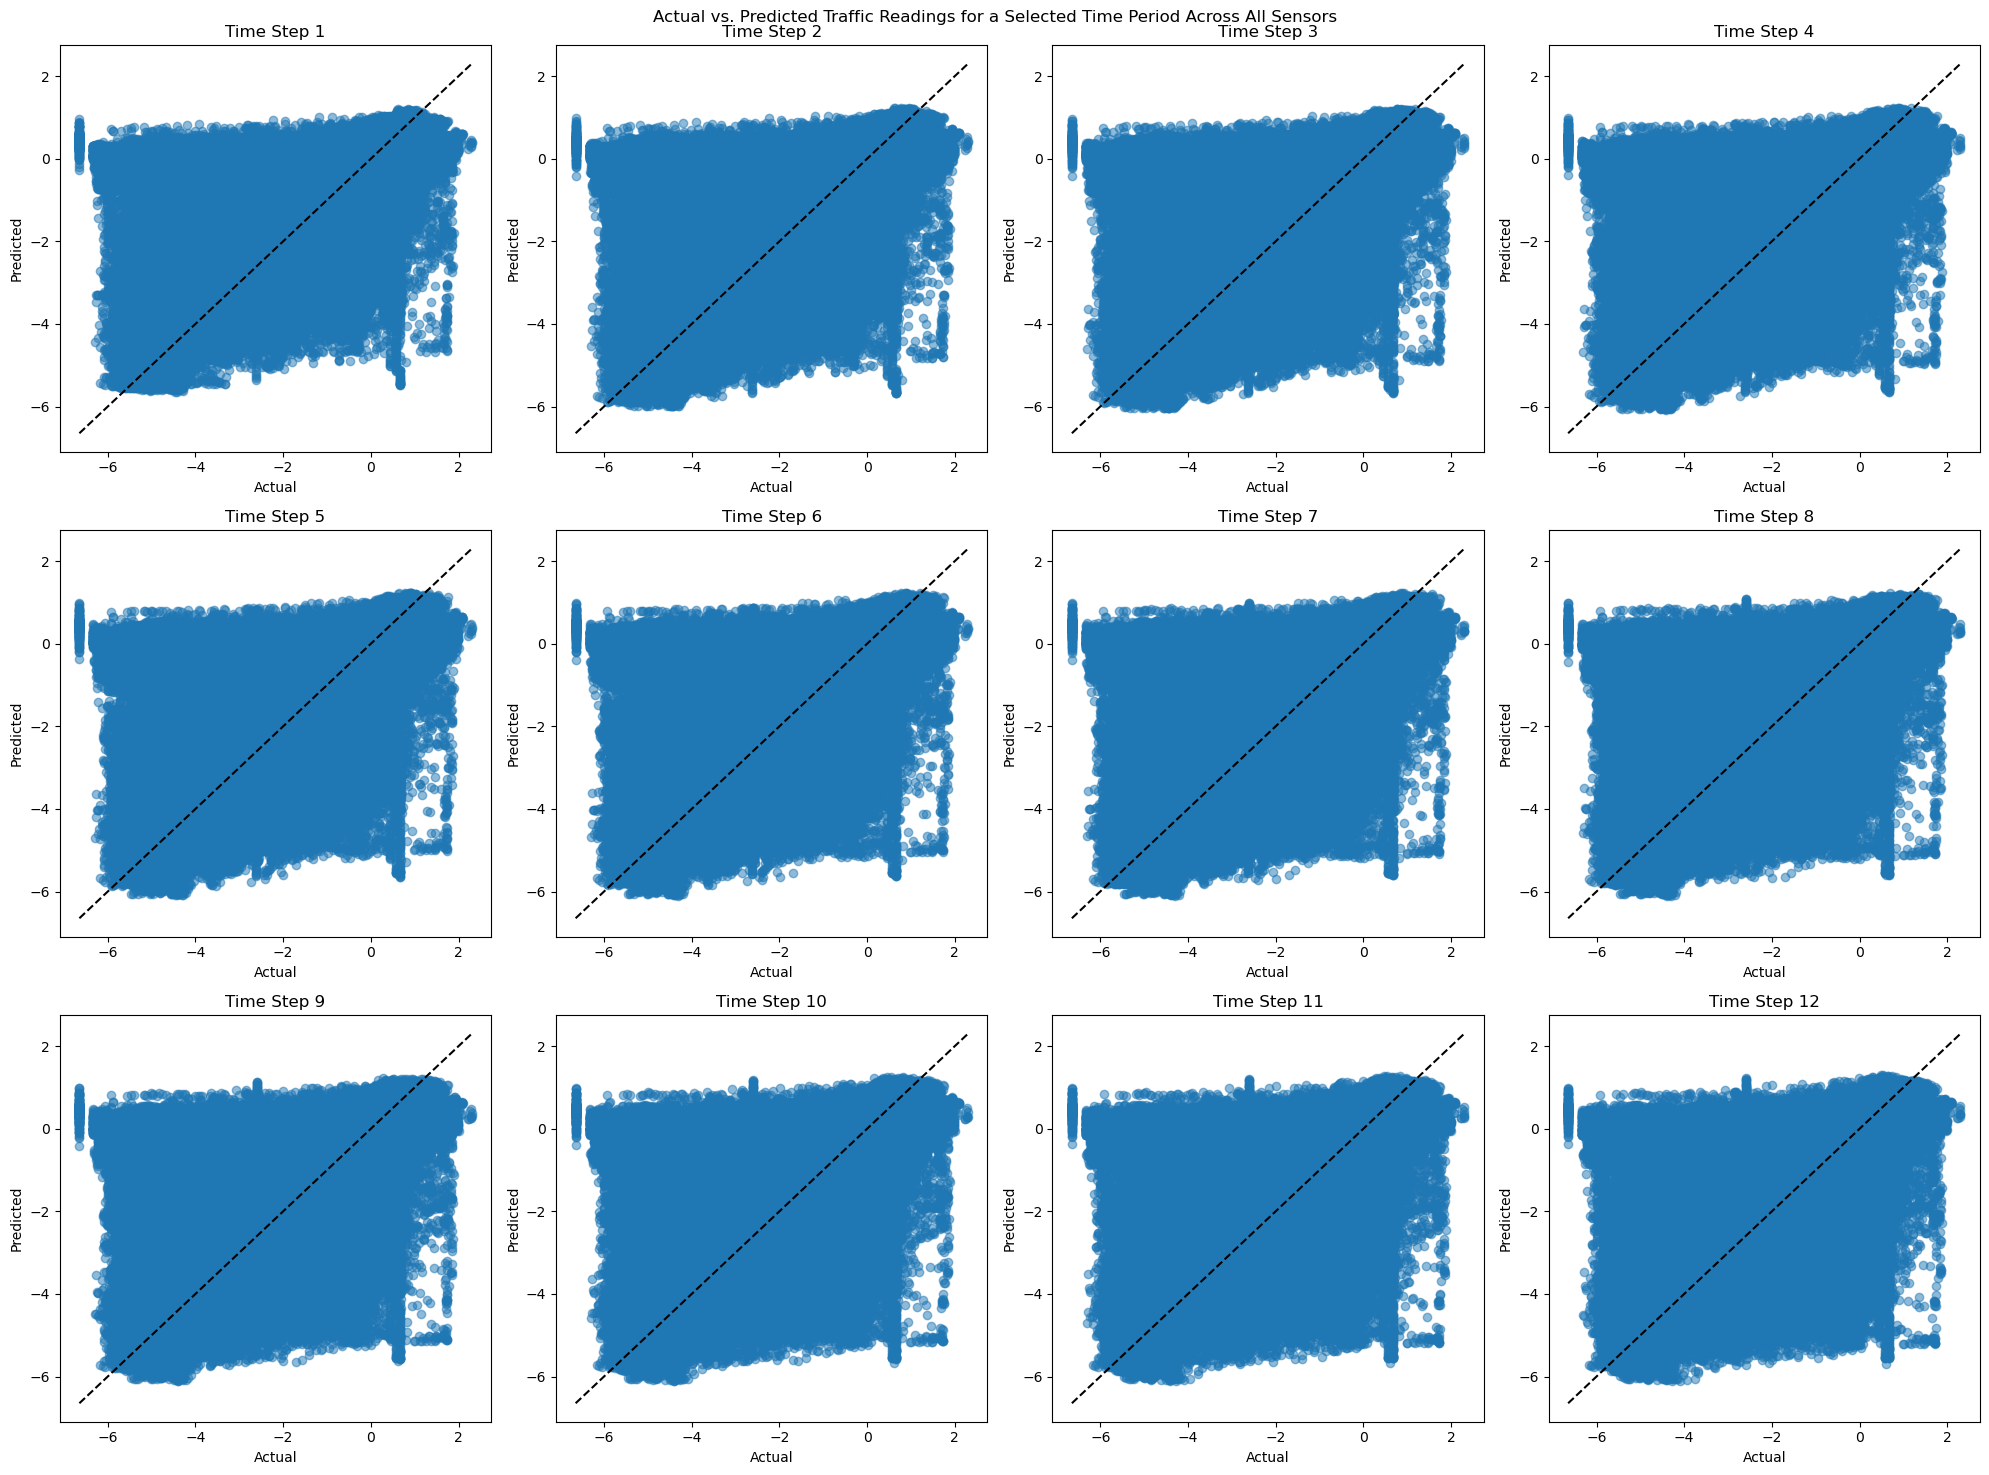

In [28]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15)) 
fig.suptitle('Actual vs. Predicted Traffic Readings for a Selected Time Period Across All Sensors')

for i in range(12): 
    ax = axes.flatten()[i]
    ax.scatter(y_true[:, i, :], y_pred[:, i, :], alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')  # Diagonal line for reference
    ax.set_title(f'Time Step {i+1}')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
plt.tight_layout()


The scatter plots above compare the actual traffic readings (x-axis) with the predicted traffic readings (y-axis) for each of the 12 time steps across all sensors. Each subplot corresponds to a different time step within a selected time period. The diagonal dashed line represents the line of perfect prediction, where the predicted values are exactly equal to the actual values.

Prediction Distribution: The points are spread out across the width of the plot, rather than being clustered around the diagonal line. This suggests that the predictions are quite varied and do not consistently match the actual values.

Bias in Prediction: There doesn't seem to be a systematic bias towards over or under prediction, as the points are not consistently above or below the diagonal. Instead, the predictions are scattered on both sides of the line.

Prediction Accuracy: The model's predictions are not highly accurate, as the points would be closer to the diagonal line if they were. The spread of the points indicates a significant variance between the actual and predicted values.

Consistency Across Time Steps: The pattern appears consistent across all time steps, indicating that the model's performance is relatively uniform over time. There's no particular time step where the model performs significantly better or worse.

Outliers: There may be outliers or extreme values that the model does not predict well, as indicated by points that are far from the diagonal line.

Normalization Effect: The values are normalized (likely z-scores given the range around 0), which makes it easier to compare the performance across different magnitudes of traffic readings. However, this normalization also means that you need to consider the actual value range when interpreting the model's performance (e.g., a small absolute error might be significant for low-traffic sensors but not for high-traffic ones).

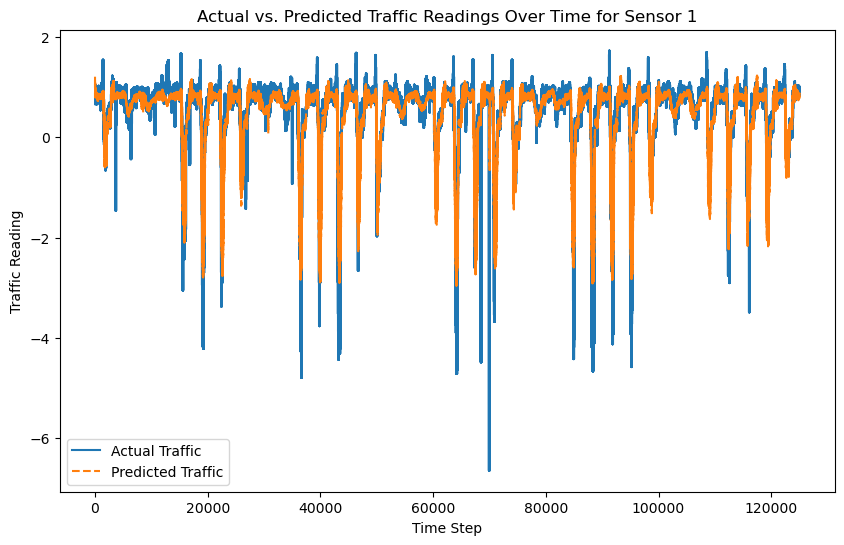

In [29]:

sensor_index = 0 
plt.figure(figsize=(10, 6))
plt.plot(y_true[:, :, sensor_index].flatten(), label='Actual Traffic')
plt.plot(y_pred[:, :, sensor_index].flatten(), label='Predicted Traffic', linestyle='--')
plt.title(f'Actual vs. Predicted Traffic Readings Over Time for Sensor {sensor_index+1}')
plt.xlabel('Time Step')
plt.ylabel('Traffic Reading')
plt.legend()
plt.show()

Based on the above line plot, which compares the actual traffic readings (in blue) to the predicted traffic readings (in orange) over time for Sensor 1, we can make the followning conculsions

Tracking Trend: The predicted traffic readings generally seem to follow the trend of the actual traffic readings closely. This indicates that the model has learned the general pattern of traffic for this particular sensor.

Variance and Peaks: There are points where the predicted values diverge from the actual values, especially noticeable at the peaks and troughs. This could indicate that while the model captures the overall trend, it might struggle with more detailed fluctuations or rapid changes in traffic conditions.

Consistency: The model's predictions appear consistent over the entire time horizon, which suggests that the model's performance is stable across different times and not just fitted to a particular subset of the data.

Noise Sensitivity: The model may not be very sensitive to noise or smaller fluctuations. It seems to smooth out some of the variability seen in the actual data, which could be a feature or a drawback depending on the desired application of the model.

Error Magnitude: The magnitude of the errors (the vertical distance between the blue and orange lines) is relatively small for most of the time steps, indicating that the model's predictions are often close to the actual readings. However, without concrete error metrics (like RMSE), it's difficult to quantify the performance precisely.